In [14]:
import pandas as pd
import numpy as np
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Dropout, Input, Conv1D, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg',
                   'mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
data = data[columns_to_keep]


In [15]:
data['species'].unique()

array(['MOJARRA', 'OTRAS', 'CORVINA', 'PARGO', 'SIERRA', 'TIBURON',
       'JUREL', 'GUACHINANGO', 'RONCO', 'BANDERA', 'LANGOSTA',
       'BERRUGATA', 'ROBALO', 'BAQUETA', 'LENGUADO', 'CABRILLA', 'MERO',
       'OSTION', 'JAIBA', 'LISA', 'BONITO', 'PAMPANO', 'LANGOSTINO',
       'LOBINA', 'CARACOL', 'ALMEJA', 'ESMEDREGAL', 'PIERNA', 'BARRILETE',
       'CALAMAR', 'ATUN', 'CAZON', 'ERIZO', 'SARDINA', 'RAYA Y SIMILARES',
       'ABULON', 'PULPO', 'ALGAS', 'CAMARON', 'RUBIO', 'CHARAL',
       'PEPINO DE MAR', 'MACARELA', 'CINTILLA', 'LEBRANCHA',
       'RUBIA Y VILLAJAIBA', 'FAUNA', 'PETO', 'SARGAZO', 'ANCHOVETA',
       'BESUGO'], dtype=object)

In [16]:
data['Cluster_Label'].unique()

array([7, 0, 3, 6, 5, 2, 1, 4])

In [17]:
# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', 'mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y, scaler

# Crear el modelo LSTM
def create_lstm_model(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(25, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(12, activation='linear')(x)
    lstm_output = Dense(1, activation='linear')(x)
    return Model(inputs=lstm_input, outputs=lstm_output)

# Crear el modelo DNN
def create_dnn_model(input_shape):
    dnn_input = Input(shape=(input_shape[0], input_shape[1]))
    x = Flatten()(dnn_input)
    x = Dense(10, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    dnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=dnn_input, outputs=dnn_output)

# Crear el modelo CNN
def create_cnn_model(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu')(cnn_input)
    x = Flatten()(x)
    cnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=cnn_input, outputs=cnn_output)

# Crear el modelo Mixture of Experts (MoE)
def create_moe_model(input_shape):
    # Definir los expertos
    lstm_model = create_lstm_model(input_shape)
    dnn_model = create_dnn_model(input_shape)
    cnn_model = create_cnn_model(input_shape)
    
    # Definir el gating network
    moe_input = Input(shape=input_shape)
    x = Flatten()(moe_input)
    x = Dense(10, activation='relu')(x)
    gate_output = Dense(3, activation='softmax')(x)  # Tres expertos

    # Obtener las salidas de los expertos
    lstm_output = lstm_model(moe_input)
    dnn_output = dnn_model(moe_input)
    cnn_output = cnn_model(moe_input)
    
    # Combinar las salidas usando el gating network
    output = concatenate([lstm_output * gate_output[:, 0:1],
                          dnn_output * gate_output[:, 1:2],
                          cnn_output * gate_output[:, 2:3]], axis=1)
    output = Dense(1, activation='linear')(output)
    
    model = Model(inputs=moe_input, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


In [18]:
# Función para entrenar y guardar el modelo MoE
def train_and_save_moe_model(data, species_name, cluster_label, look_back=look_back, epochs=50, batch_size=1):
    X, y, scaler = prepare_data(data, look_back)
    model = create_moe_model((look_back, X.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo y el scaler
    model_directory = 'modelos_moe'
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_model.h5')
    scaler_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_scaler.pkl')
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    # Guardar los valores de monitoreo del entrenamiento
    train_moe_directory = 'train_moe'
    os.makedirs(train_moe_directory, exist_ok=True)
    history_path = os.path.join(train_moe_directory, f'{species_name}_cluster_{cluster_label}_training_history.csv')
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    
    print(f'Modelo MoE, scaler y datos de entrenamiento guardados para {species_name} en clúster {cluster_label}')
    return model, scaler

# Función para hacer predicciones con bandas de confianza usando bootstrap
def predict_with_confidence_intervals(model, scaler, data, look_back=6, n_bootstrap=100, alpha=0.01):
    features = ['landed_w_kg','Cluster_Label','mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
    group_scaled = scaler.transform(data[features])

    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, X[:, -1, 1:])))[:, 0]
    
    # Bootstrap para bandas de confianza
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(range(len(X)), len(X), replace=True)
        X_sample = X[indices]
        pred_sample = model.predict(X_sample)
        pred_sample = scaler.inverse_transform(np.hstack((pred_sample, X_sample[:, -1, 1:])))[:, 0]
        bootstrap_predictions.append(pred_sample)
    
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    
    return predictions, lower_bound, upper_bound



In [19]:
# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Definir la especie y clúster desde donde retomar el proceso y detenerlo
start_species = 'LOBINA'
start_cluster = 7.0
stop_species = 'CAZON'
stop_cluster = 4.0

# Inicializar banderas
start_training = False
stop_training = False

for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Activar la bandera cuando se alcance la especie y clúster deseados para iniciar
        if species_name == start_species and cluster_label == start_cluster:
            start_training = True
        
        # Detener el proceso cuando se alcance la especie y clúster deseados para detener
        if species_name == stop_species and cluster_label == stop_cluster:
            stop_training = True
        
        # Continuar solo si la bandera de inicio está activada y la de detener no lo está
        if start_training and not stop_training:
            # Filtrar los datos para obtener una especie y un clúster específico
            filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]
            
            if len(filtered_data) >= look_back:
                filtered_data = filtered_data.sort_values('date')
                try:
                    print(f'Training model for species: {species_name}, cluster: {cluster_label}')
                    model, scaler = train_and_save_moe_model(filtered_data, species_name, cluster_label, look_back)

                    # Guardar los datos para las bandas de confianza
                    test_data_2023 = filtered_data[(filtered_data['date'].dt.year == 2023) & (filtered_data['date'].dt.month >= 1)]
                    if len(test_data_2023) >= look_back:
                        predictions, lower_bound, upper_bound = predict_with_confidence_intervals(model, scaler, test_data_2023, look_back)
                        real_values = test_data_2023['landed_w_kg'].values[look_back:]
                        
                        # Crear un DataFrame para los resultados
                        results_df = pd.DataFrame({
                            'date': test_data_2023['date'].values[look_back:],
                            'real_values': real_values,
                            'predictions': predictions,
                            'lower_bound': lower_bound,
                            'upper_bound': upper_bound
                        })
                        
                        # Guardar los resultados
                        results_directory = 'resultados_moe'
                        os.makedirs(results_directory, exist_ok=True)
                        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
                        results_df.to_csv(results_path, index=False)
                        
                        # Agrupar por mes y sumar los valores
                        monthly_totals = results_df.set_index('date').resample('M').sum()
                        
                        # Calcular MSE y R2 para los totales mensuales
                        mse = mean_squared_error(monthly_totals['real_values'], monthly_totals['predictions'])
                        r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                        print(f'MSE Mensual para {species_name} en clúster {cluster_label}: {mse}, R2 Mensual: {r2}')
                        
                        # Crear figura
                        plt.figure(figsize=(10, 6))
                        plt.plot(monthly_totals.index, monthly_totals['real_values'], color='blue', label='Real')
                        plt.plot(monthly_totals.index, monthly_totals['predictions'], color='red', linestyle='--', label='Predicho')
                        plt.fill_between(monthly_totals.index, monthly_totals['lower_bound'], monthly_totals['upper_bound'], color='gray', alpha=0.2, label='Intervalo de Confianza 95%')
                        plt.title(f'Totales Mensuales de {species_name} en clúster {cluster_label} para los Últimos Seis Meses de 2023')
                        plt.xlabel('Fecha')
                        plt.ylabel('Peso Desembarcado (kg)')
                        plt.legend()
                        plot_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_plot.png')
                        plt.savefig(plot_path)
                        plt.close()
                    else:
                        print(f'No se tienen datos suficientes para {species_name} en clúster {cluster_label} en los últimos seis meses de 2023')
                except Exception as e:
                    print(f'Error entrenando el modelo para especie: {species_name}, clúster: {cluster_label}. Error: {e}')
        
        # Salir del bucle si se alcanza el punto de detener
        if stop_training:
            break
    if stop_training:
        break

Training model for species: LOBINA, cluster: 7
Epoch 1/50
172/172 [==============================] - 4s 8ms/step - loss: 0.0055 - val_loss: 0.0342
Epoch 2/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 0.0383
Epoch 3/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0342
Epoch 4/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0339
Epoch 5/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0343
Epoch 6/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0347
Epoch 7/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0344
Epoch 8/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0352
Epoch 9/50
172/172 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0346
Epoch 10/50
172/172 [==============================] 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 3ms/step
MSE Mensual para LOBINA en clúster 7: 72851.49310898657, R2 Mensual: -1.8405463839430176


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LOBINA, cluster: 3
Epoch 1/50
267/267 [==============================] - 5s 7ms/step - loss: 0.0197 - val_loss: 0.0059
Epoch 2/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0027
Epoch 3/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0026
Epoch 4/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0025
Epoch 5/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0094
Epoch 6/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0103
Epoch 7/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0042
Epoch 8/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0028
Epoch 9/50
267/267 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0025
Epoch 10/50
267/267 [==============================] 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para LOBINA en clúster 3: 51108.80074758275, R2 Mensual: -22.058017094480753
Training model for species: LOBINA, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.7747 - val_loss: 1.1133
Epoch 2/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6682 - val_loss: 1.0946
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 0.5743 - val_loss: 1.0722
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.4869 - val_loss: 1.0428
Epoch 5/50
1/1 [==============================] - 0s 31ms/step - loss: 0.4069 - val_loss: 1.0118
Epoch 6/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3352 - val_loss: 0.9795
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2693 - val_loss: 0.9460
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2106 - val_loss: 0.9117
Epoch 9/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1568 - val_loss: 0.8776
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1162 - val_loss: 0.8435
Epoch 11/50
1/1 [==============

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
132/132 [==============================] - 4s 10ms/step - loss: nan - val_loss: nan
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de ent

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para LOBINA en clúster 2: 56082.5, R2 Mensual: -0.2796040705475791
Training model for species: LOBINA, cluster: 1


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
530/530 [==============================] - 6s 6ms/step - loss: 0.0193 - val_loss: 0.0343
Epoch 2/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0155 - val_loss: 0.0326
Epoch 3/50
530/530 [==============================] - 2s 5ms/step - loss: 0.0153 - val_loss: 0.0349
Epoch 4/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0145 - val_loss: 0.0354
Epoch 5/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0139 - val_loss: 0.0346
Epoch 6/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0139 - val_loss: 0.0525
Epoch 7/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0135 - val_loss: 0.0357
Epoch 8/50
530/530 [==============================] - 2s 5ms/step - loss: 0.0132 - val_loss: 0.0491
Epoch 9/50
530/530 [==============================] - 2s 5ms/step - loss: 0.0125 - val_loss: 0.0522
Epoch 10/50
530/530 [==============================] - 3s 5ms/step - loss: 0.0122 - val_loss: 0.0295

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 3ms/step
MSE Mensual para LOBINA en clúster 1: 802797.0790845398, R2 Mensual: 0.9426147636784391


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CARACOL, cluster: 3
Epoch 1/50
914/914 [==============================] - 8s 5ms/step - loss: 0.0155 - val_loss: 0.0015
Epoch 2/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0134 - val_loss: 0.0010
Epoch 3/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0127 - val_loss: 3.3823e-04
Epoch 4/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0119 - val_loss: 0.0011
Epoch 5/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0119 - val_loss: 4.2959e-04
Epoch 6/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0114 - val_loss: 3.4514e-04
Epoch 7/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0114 - val_loss: 0.0014
Epoch 8/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0113 - val_loss: 4.4185e-04
Epoch 9/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0113 - val_loss: 8.9871e-04
Epoch 10/50
914/914 [===========

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 3: 7731547.706923258, R2 Mensual: 0.5584288057880782
Training model for species: CARACOL, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
4123/4123 [==============================] - 23s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 2/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0017 - val_loss: 9.5200e-04
Epoch 6/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0017 - val_loss: 9.7160e-04
Epoch 7/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0017 - val_loss: 9.9315e-04
Epoch 9/50
4123/4123 [==============================] - 19s 5ms/step - loss: 0.0017 - val_loss: 9.9471e-04
Epoch 10/50
4123/4123 [==============================] - 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 6: 3211445998.068014, R2 Mensual: 0.7974944155541009
Training model for species: CARACOL, cluster: 5


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
50/50 [==============================] - 4s 17ms/step - loss: nan - val_loss: nan
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para CARACOL en clúster 5: 1353751939.6666667, R2 Mensual: -0.8395088194681799
Training model for species: CARACOL, cluster: 2


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0275 - val_loss: nan
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0145 - val_loss: nan
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 0.0059 - val_loss: nan
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: nan
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 3.3344e-05 - val_loss: nan
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: nan
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: nan
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0052 - val_loss: nan
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0054 - val_loss: nan
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 0.0046 - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de en

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4085/4085 [==============================] - 23s 5ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 2/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 3/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 4/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 5/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 6/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 8/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 9/50
4085/4085 [==============================] - 19s 5ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/50
4085/4085 [==============================] - 19s 5ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 1: 313546766.5811065, R2 Mensual: 0.7595358398663267
Training model for species: CARACOL, cluster: 4


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
61/61 [==============================] - 4s 15ms/step - loss: nan - val_loss: nan
Epoch 2/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
61/61 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para CARACOL en clúster 4: 837726.2222222222, R2 Mensual: -2.2121209596548685
Training model for species: ALMEJA, cluster: 0


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
30/30 [==============================] - 4s 26ms/step - loss: 0.0698 - val_loss: 0.0064
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0646 - val_loss: 0.0065
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0554 - val_loss: 0.0066
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0539 - val_loss: 0.0071
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.0074
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0627 - val_loss: 0.0072
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0494 - val_loss: 0.0077
Epoch 8/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0087
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0508 - val_loss: 0.0090
Epoch 10/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0562 - val_loss: 0.0124
Epoch 11/50
30/30 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 0: 232342.67089338473, R2 Mensual: 0.890925014911312
Training model for species: ALMEJA, cluster: 3


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
2118/2118 [==============================] - 14s 5ms/step - loss: 0.0026 - val_loss: 5.1169e-04
Epoch 2/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 4.5232e-04
Epoch 3/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 8.8157e-04
Epoch 4/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 5.6545e-04
Epoch 5/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 4.9954e-04
Epoch 6/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 6.1323e-04
Epoch 7/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 3.7289e-04
Epoch 8/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 2.8655e-04
Epoch 9/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 2.6179e-04
Epoch 10/50
2118/2118 [==============

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 3: 1557526260.0206118, R2 Mensual: 0.21458477922636232
Training model for species: ALMEJA, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
7692/7692 [==============================] - 39s 5ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 2/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 3/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 4/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0034 - val_loss: 9.8666e-04
Epoch 5/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0034 - val_loss: 9.9805e-04
Epoch 6/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 7/50
7692/7692 [==============================] - 36s 5ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 8/50
7692/7692 [==============================] - 35s 5ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 9/50
7692/7692 [==============================] - 35s 5ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 10/50
7692/7692 [==============================] - 36s 5ms/

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 6: 249657358.27299318, R2 Mensual: 0.8082030316230251
Training model for species: ALMEJA, cluster: 5


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
852/852 [==============================] - 8s 5ms/step - loss: nan - val_loss: nan
Epoch 2/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
852/852 [==============================] - 4s 5ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entr

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 5: 2054480824.4166667, R2 Mensual: -6.097837070732745
Training model for species: ALMEJA, cluster: 2


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
15/15 [==============================] - 4s 47ms/step - loss: nan - val_loss: nan
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 10/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4223/4223 [==============================] - 23s 5ms/step - loss: 7.1937e-04 - val_loss: 8.9904e-05
Epoch 2/50
4223/4223 [==============================] - 20s 5ms/step - loss: 6.8980e-04 - val_loss: 8.7649e-05
Epoch 3/50
4223/4223 [==============================] - 20s 5ms/step - loss: 6.8684e-04 - val_loss: 8.8862e-05
Epoch 4/50
4223/4223 [==============================] - 20s 5ms/step - loss: 6.8728e-04 - val_loss: 8.8726e-05
Epoch 5/50
4223/4223 [==============================] - 20s 5ms/step - loss: 6.8791e-04 - val_loss: 8.9387e-05
Epoch 6/50
4223/4223 [==============================] - 19s 5ms/step - loss: 6.8599e-04 - val_loss: 9.0206e-05
Epoch 7/50
4223/4223 [==============================] - 19s 5ms/step - loss: 6.8766e-04 - val_loss: 9.1250e-05
Epoch 8/50
4223/4223 [==============================] - 19s 5ms/step - loss: 6.8493e-04 - val_loss: 9.0763e-05
Epoch 9/50
4223/4223 [==============================] - 19s 5ms/step - loss: 6.8637e-04 - val_loss: 9.6116e-05
E

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 1: 482645703.7999303, R2 Mensual: 0.5569711296003956
Training model for species: ALMEJA, cluster: 4


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
15/15 [==============================] - 4s 47ms/step - loss: nan - val_loss: nan
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: nan - val_loss: nan
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 10/50
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step
MSE Mensual para ALMEJA en clúster 4: 2503125.0, R2 Mensual: -0.3157030223390276
Training model for species: ESMEDREGAL, cluster: 7


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
9/9 [==============================] - 4s 81ms/step - loss: 0.0826 - val_loss: 0.2764
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0678 - val_loss: 0.2332
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0569 - val_loss: 0.2431
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0513 - val_loss: 0.2592
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0430 - val_loss: 0.2485
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0417 - val_loss: 0.2375
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0385 - val_loss: 0.2407
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0363 - val_loss: 0.2250
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0330 - val_loss: 0.2445
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.2395
Epoch 11/50
9/9 [=====================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
62/62 [==============================] - 4s 15ms/step - loss: 0.0167 - val_loss: 0.0026
Epoch 2/50
62/62 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0039
Epoch 3/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0026
Epoch 4/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0161 - val_loss: 0.0030
Epoch 5/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0065
Epoch 6/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.0036
Epoch 7/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0025
Epoch 8/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0025
Epoch 9/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0026
Epoch 10/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0026
Epoch 11/50
62/62 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 3ms/step
MSE Mensual para ESMEDREGAL en clúster 3: 8989.940376038696, R2 Mensual: 0.8122637017909473


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ESMEDREGAL, cluster: 1
Epoch 1/50
8/8 [==============================] - 4s 91ms/step - loss: 0.0196 - val_loss: 0.4731
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.4270
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.4381
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.4542
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.4417
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.4295
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.4255
Epoch 8/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.4266
Epoch 9/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.4248
Epoch 10/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
988/988 [==============================] - 9s 5ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 2/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 3/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 4/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 5/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0107
Epoch 6/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 7/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 8/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 9/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 10/50
988/988 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0111

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 3ms/step
MSE Mensual para PIERNA en clúster 3: 7913831.955984707, R2 Mensual: -0.09332820994839319
Training model for species: PIERNA, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
454/454 [==============================] - 6s 6ms/step - loss: 0.0267 - val_loss: 0.0119
Epoch 2/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0241 - val_loss: 0.0110
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0234 - val_loss: 0.0123
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0236 - val_loss: 0.0097
Epoch 5/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0235 - val_loss: 0.0105
Epoch 6/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0235 - val_loss: 0.0102
Epoch 7/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0232 - val_loss: 0.0097
Epoch 8/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0232 - val_loss: 0.0097
Epoch 9/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0230 - val_loss: 0.0113
Epoch 10/50
454/454 [==============================] - 2s 5ms/step - loss: 0.0231 - val_loss: 0.0112

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 3ms/step
MSE Mensual para PIERNA en clúster 6: 2135372.3346810737, R2 Mensual: 0.5658347823058316


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: PIERNA, cluster: 2
Error entrenando el modelo para especie: PIERNA, clúster: 2. Error: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.
Training model for species: PIERNA, cluster: 1
Epoch 1/50
1822/1822 [==============================] - 12s 5ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 2/50
1822/1822 [==============================] - 9s 5ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 3/50
1822/1822 [==============================] - 9s 5ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 4/50
1822/1822 [==============================] - 9s 5ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 5/50
1822/1822 [==============================] - 9s 5ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 6/50
1822/1822 [==============================] - 9s 5ms/step - loss: 0.0039 - val_loss: 0.0

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 0s 3ms/step
MSE Mensual para PIERNA en clúster 1: 3982888.4910464115, R2 Mensual: 0.7743387351410511
Training model for species: PIERNA, cluster: 4


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
13/13 [==============================] - 4s 52ms/step - loss: 0.2289 - val_loss: 0.1078
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0793 - val_loss: 0.0741
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0825 - val_loss: 0.0848
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0669 - val_loss: 0.1085
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0710 - val_loss: 0.0966
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0559 - val_loss: 0.1068
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0526 - val_loss: 0.1039
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1208
Epoch 9/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.1260
Epoch 10/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0440 - val_loss: 0.1459
Epoch 11/50
13/13 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
7/7 [==============================] - 4s 100ms/step - loss: 0.3356 - val_loss: 0.0344
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 0.2458 - val_loss: 0.0078
Epoch 3/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1606 - val_loss: 0.0629
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1245 - val_loss: 0.2390
Epoch 5/50
7/7 [==============================] - 0s 9ms/step - loss: 0.1251 - val_loss: 0.1600
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0887 - val_loss: 0.1271
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0816 - val_loss: 0.1442
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0582 - val_loss: 0.1677
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0567 - val_loss: 0.2092
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0521 - val_loss: 0.1784
Epoch 11/50
7/7 [===================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
91/91 [==============================] - 4s 12ms/step - loss: 0.0318 - val_loss: 0.0729
Epoch 2/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0291 - val_loss: 0.0681
Epoch 3/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0286 - val_loss: 0.0685
Epoch 4/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0281 - val_loss: 0.0699
Epoch 5/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.0625
Epoch 6/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0269 - val_loss: 0.0613
Epoch 7/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0640
Epoch 8/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0255 - val_loss: 0.0737
Epoch 9/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0245 - val_loss: 0.0692
Epoch 10/50
91/91 [==============================] - 0s 5ms/step - loss: 0.0248 - val_loss: 0.0630
Epoch 11/50
91/91 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step
MSE Mensual para BARRILETE en clúster 3: 1115289.0943824984, R2 Mensual: 0.9678521104916069


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: BARRILETE, cluster: 1
Epoch 1/50
9/9 [==============================] - 4s 77ms/step - loss: 0.0721 - val_loss: 0.3049
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0224 - val_loss: 0.2420
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 0.2143
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0145 - val_loss: 0.2089
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.2140
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.2244
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.2265
Epoch 8/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0094 - val_loss: 0.2127
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.2095
Epoch 10/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0088 - val_l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
316/316 [==============================] - 5s 7ms/step - loss: 0.0080 - val_loss: 0.0039
Epoch 2/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 3/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 4/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 5/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0037
Epoch 6/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 7/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 8/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 9/50
316/316 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 10/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0075 - val_loss: 0.0042

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step
MSE Mensual para CALAMAR en clúster 3: 1232168.1549133384, R2 Mensual: 0.7756593252500344
Training model for species: CALAMAR, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
142/142 [==============================] - 4s 9ms/step - loss: 0.0089 - val_loss: 0.0073
Epoch 2/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 4.1087e-04
Epoch 3/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 3.6667e-04
Epoch 4/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 5/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 8.2005e-04
Epoch 6/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 6.2944e-05
Epoch 7/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 1.8355e-04
Epoch 8/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 9/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0077 - val_loss: 2.7213e-04
Epoch 10/50
142/142 [==============================] - 1s 5ms/step - loss: 0

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 4ms/step
MSE Mensual para CALAMAR en clúster 6: 4441895.051346014, R2 Mensual: -3.467531890796974


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CALAMAR, cluster: 1
Epoch 1/50
2739/2739 [==============================] - 17s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 2/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/50
2739/2739 [==

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 3ms/step
MSE Mensual para CALAMAR en clúster 1: 505059141.7667151, R2 Mensual: -0.21279883407170241
Training model for species: CALAMAR, cluster: 4


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Error entrenando el modelo para especie: CALAMAR, clúster: 4. Error: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.
Training model for species: ATUN, cluster: 7
Epoch 1/50
16/16 [==============================] - 4s 45ms/step - loss: 0.1400 - val_loss: 0.0253
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0998 - val_loss: 0.0153
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0834 - val_loss: 0.0135
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0815 - val_loss: 0.0136
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0812 - val_loss: 0.0145
Epoch 6/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0747 - val_loss: 0.0148
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - lo

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
213/213 [==============================] - 5s 8ms/step - loss: 0.0046 - val_loss: 0.0245
Epoch 2/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0249
Epoch 3/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 0.0241
Epoch 4/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 0.0242
Epoch 5/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 0.0245
Epoch 6/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0241
Epoch 7/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0236
Epoch 8/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0243
Epoch 9/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0237
Epoch 10/50
213/213 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0246

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step
MSE Mensual para ATUN en clúster 3: 183588.85982410674, R2 Mensual: -19.66827652861162


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ATUN, cluster: 1
Error entrenando el modelo para especie: ATUN, clúster: 1. Error: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.
Training model for species: CAZON, cluster: 7
Epoch 1/50
1040/1040 [==============================] - 8s 5ms/step - loss: 0.0156 - val_loss: 0.0233
Epoch 2/50
1040/1040 [==============================] - 5s 4ms/step - loss: 0.0150 - val_loss: 0.0241
Epoch 3/50
1040/1040 [==============================] - 5s 4ms/step - loss: 0.0148 - val_loss: 0.0261
Epoch 4/50
1040/1040 [==============================] - 5s 4ms/step - loss: 0.0147 - val_loss: 0.0241
Epoch 5/50
1040/1040 [==============================] - 5s 5ms/step - loss: 0.0146 - val_loss: 0.0241
Epoch 6/50
1040/1040 [==============================] - 5s 5ms/step - loss: 0.0145 - val_loss: 0.0243
Ep

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 3ms/step
MSE Mensual para CAZON en clúster 7: 17008565.493495252, R2 Mensual: 0.818877278863275
Training model for species: CAZON, cluster: 0


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
6/6 [==============================] - 4s 120ms/step - loss: nan - val_loss: nan
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados para CAZON e

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
1060/1060 [==============================] - 9s 5ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 2/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 3/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 4/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 5/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 6/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 8/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 9/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 10/50
1060/1060 [==============================] - 5s 5ms/step - loss: 0.004

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 3ms/step
MSE Mensual para CAZON en clúster 3: 593608539.7904496, R2 Mensual: 0.7611316838556592
Training model for species: CAZON, cluster: 6


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
2248/2248 [==============================] - 14s 5ms/step - loss: 0.0054 - val_loss: 0.0087
Epoch 2/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0091
Epoch 3/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 4/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 5/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0090
Epoch 6/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 7/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 8/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 9/50
2248/2248 [==============================] - 10s 5ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 10/50
2248/2248 [==============================] - 10s 5ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 3ms/step
MSE Mensual para CAZON en clúster 6: 147320752.93584105, R2 Mensual: 0.9300922966875897
Training model for species: CAZON, cluster: 5


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
64/64 [==============================] - 4s 14ms/step - loss: nan - val_loss: nan
Epoch 2/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
64/64 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 3ms/step
MSE Mensual para CAZON en clúster 5: 27753795.454545453, R2 Mensual: -0.709290394236396
Training model for species: CAZON, cluster: 2


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: nan - val_loss: nan
Epoch 2/50
1/1 [==============================] - 0s 26ms/step - loss: nan - val_loss: nan
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: nan - val_loss: nan
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: nan - val_loss: nan
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: nan - val_loss: nan
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: nan - val_loss: nan
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: nan - val_loss: nan
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: nan - val_loss: nan
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: nan - val_loss: nan
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados para CAZON e

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
3411/3411 [==============================] - 20s 5ms/step - loss: 0.0020 - val_loss: 0.0090
Epoch 2/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 3/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 4/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0019 - val_loss: 0.0082
Epoch 5/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch 6/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 7/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0019 - val_loss: 0.0082
Epoch 8/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 9/50
3411/3411 [==============================] - 16s 5ms/step - loss: 0.0018 - val_loss: 0.0082
Epoch 10/50
3411/3411 [==============================] - 16s 5ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 3ms/step
MSE Mensual para CAZON en clúster 1: 1298945751.6455898, R2 Mensual: 0.8638288521653321


/var/tmp/ipykernel_193283/1901382260.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


In [24]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de R2
r2_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular el R2
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Calcular el R2 para los totales mensuales, si hay suficientes datos
            if not monthly_totals.empty:
                r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el R2 en el DataFrame
                r2_df.at[species_name, cluster_label] = r2
            else:
                #print(f'Sin datos suficientes para calcular R2 para especie: {species_name}, clúster: {cluster_label}')
                r2_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r2_df.at[species_name, cluster_label] = None

# Guardar el DataFrame de R2 en un archivo CSV
r2_output_path = os.path.join(results_directory, 'r2_scores.csv')
r2_df.to_csv(r2_output_path)

print(f'Tabla de R2 guardada en: {r2_output_path}')

Tabla de R2 guardada en: resultados_moe/r2_scores.csv


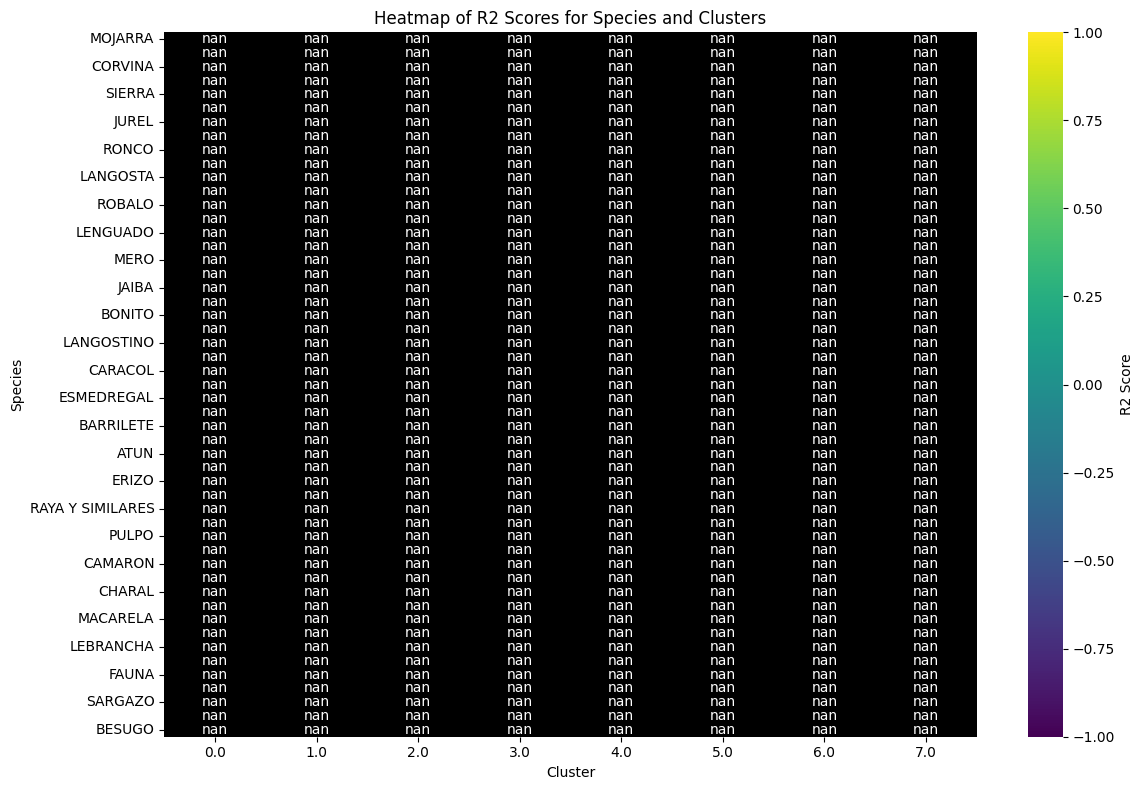

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Asegurar que las columnas estén en formato string y reindexar
r2_df.columns = r2_df.columns.astype(str)
r2_df = r2_df.reindex(columns=column_order)

# Asegurar que el índice también esté en formato string
r2_df.index = r2_df.index.astype(str)

# Reemplazar valores None o NaN con np.nan
r2_df = r2_df.apply(pd.to_numeric, errors='coerce')

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r2_df < -1) | (r2_df > 1) | r2_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(r2_df, annot=True, cmap='viridis', cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"})

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r2_df.shape[0]):
    for j in range(r2_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.2f}'.format(r2_df.iloc[i, j]), ha='center', va='center', color='white')

# Añadir títulos y etiquetas
plt.title('Heatmap of R2 Scores for Species and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()



In [26]:
r2_df.to_csv('tabla_resultados.csv')

/var/tmp/ipykernel_193283/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_193283/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_193283/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_193283/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_193283/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not

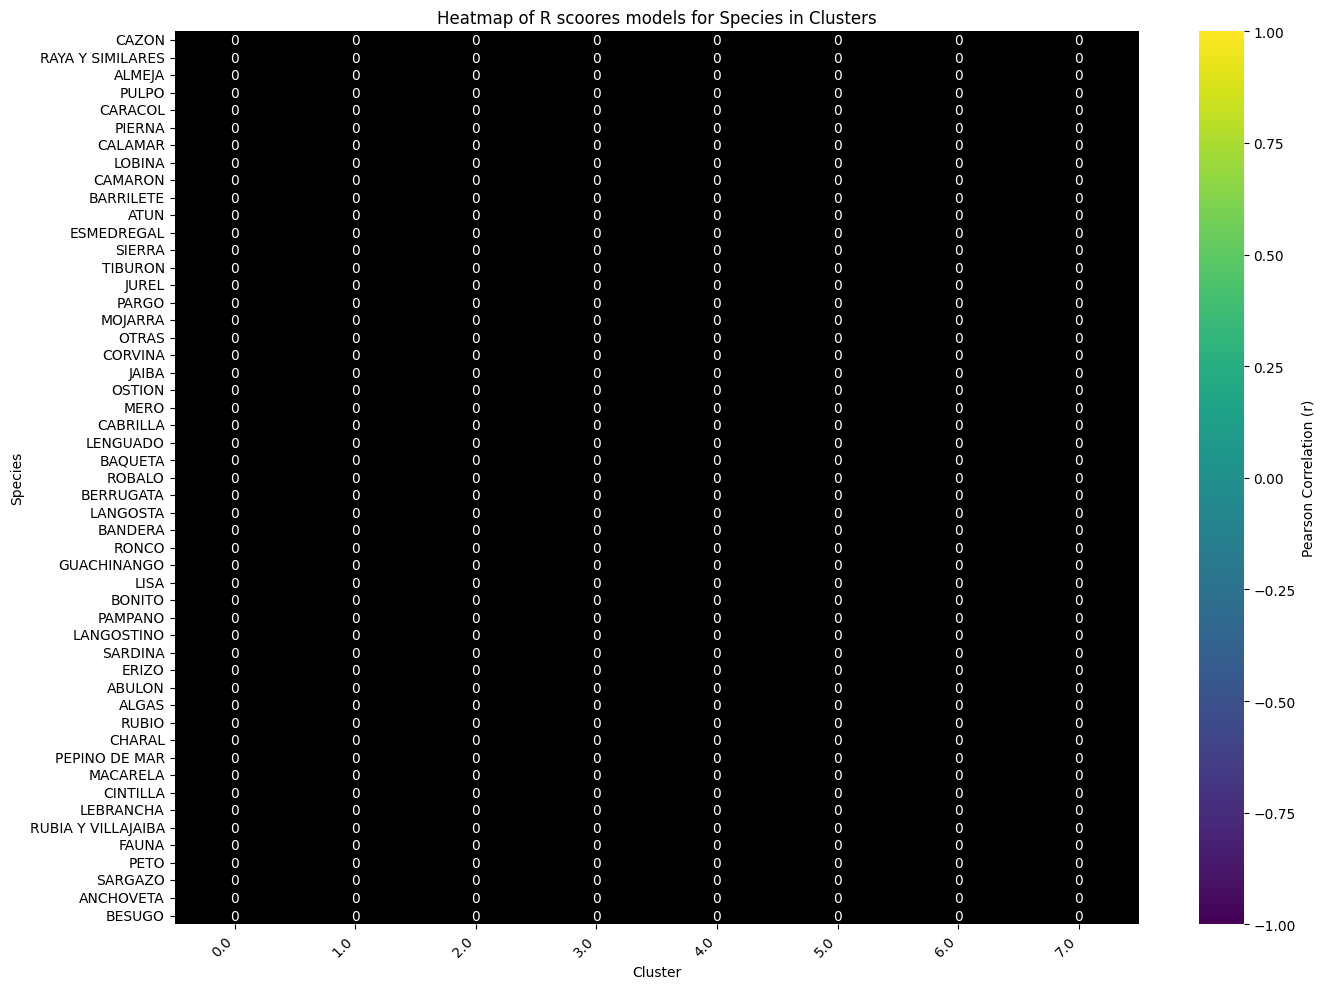

In [23]:
import os
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de r
r_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular el coeficiente de correlación de Pearson (r)
            if len(monthly_totals) >= 2:
                r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el valor de r en el DataFrame
                r_df.at[species_name, cluster_label] = r
            else:
                print(f'Sin datos suficientes para calcular r para especie: {species_name}, clúster: {cluster_label}')
                r_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r_df.at[species_name, cluster_label] = None

# Reemplazar valores None o NaN con np.nan
r_df = r_df.apply(pd.to_numeric, errors='coerce')

# Contar los valores no nulos por fila y ordenar las especies
r_df['non_null_count'] = r_df.notnull().sum(axis=1)
r_df = r_df.sort_values(by='non_null_count', ascending=False).drop(columns=['non_null_count'])

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Reindexar el DataFrame según el orden de las columnas
r_df.columns = r_df.columns.astype(str)
r_df = r_df.reindex(columns=column_order)
r_df.index = r_df.index.astype(str)

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r_df < -1) | (r_df > 1) | r_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(r_df, annot=True, cmap='viridis', cbar_kws={'label': 'Pearson Correlation (r)'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"}, fmt=".4g")

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r_df.shape[0]):
    for j in range(r_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.4g}'.format(r_df.iloc[i, j] if not np.isnan(r_df.iloc[i, j]) else 0), ha='center', va='center', color='white')

# Ajustar los ticks de los ejes para mayor claridad
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de las columnas
plt.yticks(rotation=0)  # Asegurar que las etiquetas de los renglones estén rectas

# Añadir títulos y etiquetas
plt.title('Heatmap of R scoores models for Species in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()
